In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils
import plotly.express as px

In [2]:
from scipy import ndimage
from pickle import load

In [3]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [4]:
train_data_directory = r'../../train_data'
test_data_directory = r'../../test_data'
saved_models_directory = r'../../saved_models'
submissions_directory = r'../../submissions'

### Load mean and std values of training dataset

In [5]:
means_stds_arrays = np.load(os.path.join(
    train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

### Load scalers for parameters

In [6]:
parameters_scalers = dict()
parameters_scalers['P'] = load((open(os.path.join(train_data_directory, 'standard_scaler_P.pkl'), 'rb')))
parameters_scalers['K'] = load((open(os.path.join(train_data_directory, 'standard_scaler_K.pkl'), 'rb')))
parameters_scalers['Mg'] = load((open(os.path.join(train_data_directory, 'standard_scaler_Mg.pkl'), 'rb')))
parameters_scalers['pH'] = load((open(os.path.join(train_data_directory, 'standard_scaler_pH.pkl'), 'rb')))

In [7]:
parameters_scalers['P'].mean_

array([70.30265589])

### Dataset definition

In [8]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False, parameters_scalers=None):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['sample_index', 'P', 'K', 'Mg', 'pH']]
        else:
            self.gt = None
        self.transform = transform  # whether to perform transformation of input data
        # whether to perform transformations like on training data
        self.train_transforms = train_transforms

        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])

        self.means = means  # mean values for every band used to normalize data
        self.stds = stds  # std values for every band used to normalize data

        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )

        if parameters_scalers is not None:
            self.scaler_P = parameters_scalers['P']
            self.scaler_K = parameters_scalers['K']
            self.scaler_Mg = parameters_scalers['Mg']
            self.scaler_pH = parameters_scalers['pH']
        else:
            self.scaler_P = None
            self.scaler_K = None
            self.scaler_Mg = None
            self.scaler_pH = None

    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2

        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)

        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        # Inverting mask is necessary due to masking method in numpy
        img_tensor_mask = ~torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)

        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(
                img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(
                300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(
                    img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']
            sample_index = self.gt.loc[idx, 'sample_index']
            
            if self.scaler_P is not None:
                assert self.scaler_K is not None
                assert self.scaler_Mg is not None
                assert self.scaler_pH is not None
                
                P_gt = self.scaler_P.transform(np.array(P_gt).reshape(1, -1))[0][0]
                K_gt = self.scaler_K.transform(np.array(K_gt).reshape(1, -1))[0][0]
                Mg_gt = self.scaler_Mg.transform(np.array(Mg_gt).reshape(1, -1))[0][0]
                pH_gt = self.scaler_pH.transform(np.array(pH_gt).reshape(1, -1))[0][0]
                

            sample = {'image': img_result_tensor, 'P': P_gt,
                      'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt, 'sample_index': sample_index}
        else:
            sample = {'image': img_result_tensor}

        return sample

In [9]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(
    train_data_directory, 'train_data'), True, means, stds, train_transforms=True, parameters_scalers=parameters_scalers)

In [10]:
train_dataset, validation_dataset = random_split(train_data_whole, [1000, 732], generator=torch.Generator().manual_seed(22))
# train_dataset = torch.utils.data.Subset(train_data_whole, list(range(0, 1400)))
# validation_dataset = torch.utils.data.Subset(train_data_whole, list(range(1400, len(train_data_whole))))

### Model Definition

In [11]:
import torchvision
from torchvision import datasets, models, transforms

In [12]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet50(pretrained=False)

        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(
            7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(
            in_features=2048, out_features=1, bias=True)

    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
BATCH_SIZE = 12
EPOCHS = 300

In [15]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)

### Overfitting on single batch of data

In [19]:
model = ResNetCNN(pretrained=False)
model.to(device)

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [50]:
loss_func = torch.nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [51]:
train_data_single_batch = next(iter(train_dataloader))

In [52]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [53]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [54]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [55]:
output.shape

torch.Size([12, 1])

In [56]:
output

tensor([[0.5224],
        [1.1003],
        [0.4700],
        [0.8589],
        [0.7177],
        [1.3129],
        [0.5492],
        [0.5300],
        [1.0051],
        [0.4611],
        [1.0135],
        [0.4326]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [57]:
stacked_gt = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device)
stacked_gt

tensor([[ 0.5356],
        [-0.1899],
        [-0.5629],
        [-0.8544],
        [-0.0035],
        [-0.2544],
        [-0.2001],
        [ 1.5154],
        [ 0.0711],
        [-1.0884],
        [ 1.2441],
        [-0.0476]], device='cuda:0', dtype=torch.float64)

In [86]:
loss_func(output, stacked_gt)

tensor(0.0399, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

#### Sprawdzenie czy inwersja skalowania działa właściwie

In [81]:
gt_df = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[
    ['sample_index', 'P', 'K', 'Mg', 'pH']]

In [82]:
train_data_single_batch['sample_index']

tensor([ 489, 1677,  589, 1436, 1434, 1149,  971,  519, 1108,  250, 1648,  168])

In [85]:
gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ 86.1],
       [ 64.7],
       [ 53.7],
       [ 45.1],
       [ 70.2],
       [ 62.8],
       [ 64.4],
       [115. ],
       [ 72.4],
       [ 38.2],
       [107. ],
       [ 68.9]])

In [87]:
scaler = getattr(train_dataset.dataset, f'scaler_{parameter}')
scaler

StandardScaler()

In [88]:
scaler.inverse_transform(stacked_gt.cpu())

array([[ 86.1],
       [ 64.7],
       [ 53.7],
       [ 45.1],
       [ 70.2],
       [ 62.8],
       [ 64.4],
       [115. ],
       [ 72.4],
       [ 38.2],
       [107. ],
       [ 68.9]])

In [89]:
scaler.inverse_transform(stacked_gt.cpu()) == gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

#### Właściwa pętla overfit

In [75]:
img_data_device = train_data_single_batch['image'].to(
    device, dtype=torch.float)
stacked_gt_device = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)
scaler = getattr(train_dataset.dataset, f'scaler_P')

model = ResNetCNN(False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
model.train()

for epoch in range(301):

    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()
    
    output_cpu_inversed = scaler.inverse_transform(output_cpu)
    stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

    # Calculate MSE for each class
    mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}, MSE from unscaled values: {mse_inversed}')

epoch: 0, loss: 0.8148233890533447, MSE: [0.8148234], MSE from unscaled values: [708.9206]
epoch: 10, loss: 6.066230297088623, MSE: [6.0662293], MSE from unscaled values: [5277.7993]
epoch: 20, loss: 0.4842960238456726, MSE: [0.484296], MSE from unscaled values: [421.35196]
epoch: 30, loss: 0.578209400177002, MSE: [0.57820934], MSE from unscaled values: [503.05933]
epoch: 40, loss: 0.4831942319869995, MSE: [0.48319423], MSE from unscaled values: [420.3933]
epoch: 50, loss: 0.4681563377380371, MSE: [0.46815634], MSE from unscaled values: [407.31003]
epoch: 60, loss: 0.41861408948898315, MSE: [0.41861406], MSE from unscaled values: [364.2067]
epoch: 70, loss: 0.47878122329711914, MSE: [0.47878122], MSE from unscaled values: [416.55392]
epoch: 80, loss: 0.4648648202419281, MSE: [0.46486473], MSE from unscaled values: [404.4462]
epoch: 90, loss: 0.39041459560394287, MSE: [0.3904146], MSE from unscaled values: [339.67233]
epoch: 100, loss: 0.3551666736602783, MSE: [0.35516667], MSE from uns

### Training Definition

In [16]:
parameter = 'pH'

In [18]:
save_name = "checkpoint_state_dict_ResNet50_12_05_2022_Single_Parameter_Scaled_{}".format(parameter)
save_name

'checkpoint_state_dict_ResNet50_12_05_2022_Single_Parameter_Scaled_pH'

In [19]:
model_name = save_name+'.pth'

In [20]:
# save subsets indices to text files
np.array(train_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_train_indices.txt'), sep='|')
np.array(validation_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_validation_indices.txt'), sep='|')

In [21]:
model = ResNetCNN(False).to(device)

In [22]:
wandb.watch(model, log="None", log_freq=20)

[]

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [24]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [24]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [25]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float),
                torch.as_tensor(batch_data['P'].unsqueeze(dim=0).permute(1, 0), dtype=torch.float))

In [26]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader),
                     start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.85E-01


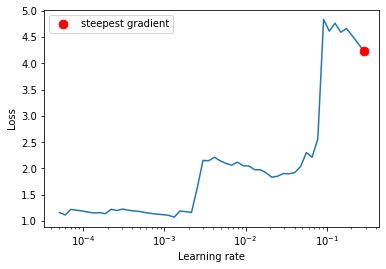

In [27]:
lr_finder.plot()
lr_finder.reset()

In [28]:
2.85E-01

0.285

### Training

In [25]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience=patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [26]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                                     path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

#### Logging training informations for W&B

In [27]:
config = wandb.config
config.model = 'resnet50'
config.optimizer = 'AdamW'
config.loss_function = 'MSELoss'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler = 'ReduceLROnPlateau'
config.scheduler_factor = 0.6
config.scheduler_patience = 5
config.scheduler_threshold = 0.0001
config.batch_size = BATCH_SIZE
config.notes = 'ResNet50 Parameter {} SCALED Training split:1000, Validation: 732. Scaled predicted variable.'.format(parameter)
config.parameter = parameter

In [28]:
previous_epochs = 0  # how many epochs have been done previously if resuming

In [29]:
scaler = getattr(train_dataset.dataset, f'scaler_{parameter}')

for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    mse_inversed_train_list = []

    bar = tqdm(train_dataloader, position=0, leave=False,
               desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar:  # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
#         stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(
#             0, 1).to(device, dtype=torch.float)
        stacked_gt_device = train_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

        output = model(img_data_device)

        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        output_cpu_inversed = scaler.inverse_transform(output_cpu)
        stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
        mse_train_list.append(mse)
        mse_inversed_train_list.append(mse_inversed)
        

        if i % 10 == 0:  # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss
            train_log_dict['train_batch_MSE_{}'.format(parameter)] = mse[0]
            wandb.log(train_log_dict)

    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(
        np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    avg_train_mse_inversed = torch.as_tensor(
        np.array(mse_inversed_train_list)).mean(axis=0).numpy().tolist()

    print(
        f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}, train MSE from unscaled values: {avg_train_mse_inversed}')
    wandb.log({'epoch': epoch, 'average_train_loss': avg_train_loss, 'average_train_MSE_{}'.format(parameter): avg_train_mse_inversed[0]})

    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0,
                   leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        mse_inversed_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
#             stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(
#                 0, 1).to(device, dtype=torch.float)
            stacked_gt_device =  val_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

            output = model(img_data_device)

            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)

            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()
            
            output_cpu_inversed = scaler.inverse_transform(output_cpu)
            stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
            mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
            mse_inversed_val_list.append(mse_inversed)


        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(
            np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        avg_val_mse_inversed = torch.as_tensor(
            np.array(mse_inversed_val_list)).mean(axis=0).numpy().tolist()

        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}, validation MSE from unscaled values: {avg_val_mse_inversed}')
        # using MSE from inversed values in W&B logger to make it compatible with previous runs in W&B
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_validation_MSE_{}'.format(parameter): avg_val_mse_inversed[0]}) 

        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

epoch 0 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 17.113985061645508, train MSE: [17.113988876342773], train MSE from unscaled values: [1.1588906049728394]


epoch 0 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 0, validation loss: 0.9931926727294922, validation MSE: [0.993192732334137], validation MSE from unscaled values: [0.06725502759218216]
Validation loss decreased (inf --> 0.993193).  Saving model ...


epoch 1 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 0.9778919219970703, train MSE: [0.9778919219970703], train MSE from unscaled values: [0.06621892005205154]


epoch 1 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 1, validation loss: 1.1337467432022095, validation MSE: [1.13374662399292], validation MSE from unscaled values: [0.0767727792263031]
EarlyStopping counter: 1 out of 13


epoch 2 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 0.9324437975883484, train MSE: [0.9324437975883484], train MSE from unscaled values: [0.0631413608789444]


epoch 2 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 2, validation loss: 1.1849697828292847, validation MSE: [1.1849697828292847], validation MSE from unscaled values: [0.08024140447378159]
EarlyStopping counter: 2 out of 13


epoch 3 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 0.9152271151542664, train MSE: [0.9152271151542664], train MSE from unscaled values: [0.06197551265358925]


epoch 3 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 3, validation loss: 0.9176726341247559, validation MSE: [0.9176726341247559], validation MSE from unscaled values: [0.06214110925793648]
Validation loss decreased (0.993193 --> 0.917673).  Saving model ...


epoch 4 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 0.9032156467437744, train MSE: [0.9032157063484192], train MSE from unscaled values: [0.06116214394569397]


epoch 4 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 4, validation loss: 0.9109119176864624, validation MSE: [0.9109119772911072], validation MSE from unscaled values: [0.06168331578373909]
Validation loss decreased (0.917673 --> 0.910912).  Saving model ...


epoch 5 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 0.9131367206573486, train MSE: [0.9131367802619934], train MSE from unscaled values: [0.06183396279811859]


epoch 5 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 5, validation loss: 1.2163695096969604, validation MSE: [1.21636962890625], validation MSE from unscaled values: [0.0823676809668541]
EarlyStopping counter: 1 out of 13


epoch 6 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 0.8988154530525208, train MSE: [0.8988154530525208], train MSE from unscaled values: [0.06086418405175209]


epoch 6 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 6, validation loss: 1.1349382400512695, validation MSE: [1.1349382400512695], validation MSE from unscaled values: [0.07685346156358719]
EarlyStopping counter: 2 out of 13


epoch 7 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 0.9095422625541687, train MSE: [0.9095422029495239], train MSE from unscaled values: [0.06159055233001709]


epoch 7 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 7, validation loss: 1.0954735279083252, validation MSE: [1.0954736471176147], validation MSE from unscaled values: [0.07418107241392136]
EarlyStopping counter: 3 out of 13


epoch 8 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 0.887067437171936, train MSE: [0.8870674967765808], train MSE from unscaled values: [0.060068659484386444]


epoch 8 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 8, validation loss: 0.9525298476219177, validation MSE: [0.9525298476219177], validation MSE from unscaled values: [0.06450149416923523]
EarlyStopping counter: 4 out of 13


epoch 9 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 0.9136373400688171, train MSE: [0.9136373400688171], train MSE from unscaled values: [0.06186787039041519]


epoch 9 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 9, validation loss: 0.9708646535873413, validation MSE: [0.9708647131919861], validation MSE from unscaled values: [0.06574306637048721]
EarlyStopping counter: 5 out of 13


epoch 10 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 10, LR: 0.01, train loss: 0.9065169095993042, train MSE: [0.9065169095993042], train MSE from unscaled values: [0.06138569489121437]


epoch 10 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 10, validation loss: 0.8889991641044617, validation MSE: [0.8889991641044617], validation MSE from unscaled values: [0.06019946187734604]
Validation loss decreased (0.910912 --> 0.888999).  Saving model ...


epoch 11 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 11, LR: 0.01, train loss: 0.8985994458198547, train MSE: [0.8985994458198547], train MSE from unscaled values: [0.06084955856204033]


epoch 11 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 11, validation loss: 1.0082385540008545, validation MSE: [1.0082385540008545], validation MSE from unscaled values: [0.0682738795876503]
EarlyStopping counter: 1 out of 13


epoch 12 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 12, LR: 0.01, train loss: 0.887639582157135, train MSE: [0.887639582157135], train MSE from unscaled values: [0.06010739132761955]


epoch 12 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 12, validation loss: 0.9837019443511963, validation MSE: [0.9837019443511963], validation MSE from unscaled values: [0.0666123554110527]
EarlyStopping counter: 2 out of 13


epoch 13 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 13, LR: 0.01, train loss: 0.8904504776000977, train MSE: [0.8904503583908081], train MSE from unscaled values: [0.060297735035419464]


epoch 13 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 13, validation loss: 1.3323837518692017, validation MSE: [1.3323837518692017], validation MSE from unscaled values: [0.09022369235754013]
EarlyStopping counter: 3 out of 13


epoch 14 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 14, LR: 0.01, train loss: 0.8979535698890686, train MSE: [0.8979535102844238], train MSE from unscaled values: [0.06080581620335579]


epoch 14 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 14, validation loss: 0.903639018535614, validation MSE: [0.903639018535614], validation MSE from unscaled values: [0.06119081377983093]
EarlyStopping counter: 4 out of 13


epoch 15 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 15, LR: 0.01, train loss: 0.8948239088058472, train MSE: [0.8948238492012024], train MSE from unscaled values: [0.060593873262405396]


epoch 15 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 15, validation loss: 0.9088250398635864, validation MSE: [0.9088250398635864], validation MSE from unscaled values: [0.06154198944568634]
EarlyStopping counter: 5 out of 13


epoch 16 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 16, LR: 0.01, train loss: 0.8766133785247803, train MSE: [0.8766133785247803], train MSE from unscaled values: [0.059360746294260025]


epoch 16 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 16, validation loss: 0.9498167634010315, validation MSE: [0.9498168230056763], validation MSE from unscaled values: [0.06431780010461807]
EarlyStopping counter: 6 out of 13


epoch 17 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 17, LR: 0.006, train loss: 0.8793854117393494, train MSE: [0.8793854117393494], train MSE from unscaled values: [0.05954845994710922]


epoch 17 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 17, validation loss: 0.8906010389328003, validation MSE: [0.8906010985374451], validation MSE from unscaled values: [0.06030793488025665]
EarlyStopping counter: 7 out of 13


epoch 18 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 18, LR: 0.006, train loss: 0.8708708882331848, train MSE: [0.8708710074424744], train MSE from unscaled values: [0.05897190049290657]


epoch 18 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 18, validation loss: 1.8818011283874512, validation MSE: [1.8818012475967407], validation MSE from unscaled values: [0.12742802500724792]
EarlyStopping counter: 8 out of 13


epoch 19 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 19, LR: 0.006, train loss: 0.8661077618598938, train MSE: [0.8661078214645386], train MSE from unscaled values: [0.058649349957704544]


epoch 19 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 19, validation loss: 0.8869044184684753, validation MSE: [0.8869044780731201], validation MSE from unscaled values: [0.0600576177239418]
Validation loss decreased (0.888999 --> 0.886904).  Saving model ...


epoch 20 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 20, LR: 0.006, train loss: 0.8703535795211792, train MSE: [0.8703535199165344], train MSE from unscaled values: [0.05893685296177864]


epoch 20 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 20, validation loss: 0.8888786435127258, validation MSE: [0.8888787031173706], validation MSE from unscaled values: [0.06019130349159241]
EarlyStopping counter: 1 out of 13


epoch 21 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 21, LR: 0.006, train loss: 0.8706657290458679, train MSE: [0.8706656694412231], train MSE from unscaled values: [0.058957990258932114]


epoch 21 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 21, validation loss: 0.8952488899230957, validation MSE: [0.8952488899230957], validation MSE from unscaled values: [0.060622669756412506]
EarlyStopping counter: 2 out of 13


epoch 22 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 22, LR: 0.006, train loss: 0.8851544260978699, train MSE: [0.8851544260978699], train MSE from unscaled values: [0.05993910878896713]


epoch 22 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 22, validation loss: 0.9718451499938965, validation MSE: [0.9718451499938965], validation MSE from unscaled values: [0.0658094584941864]
EarlyStopping counter: 3 out of 13


epoch 23 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 23, LR: 0.006, train loss: 0.8738651275634766, train MSE: [0.8738651275634766], train MSE from unscaled values: [0.05917464569211006]


epoch 23 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 23, validation loss: 0.9328192472457886, validation MSE: [0.9328192472457886], validation MSE from unscaled values: [0.0631667897105217]
EarlyStopping counter: 4 out of 13


epoch 24 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 24, LR: 0.006, train loss: 0.8645057678222656, train MSE: [0.8645058274269104], train MSE from unscaled values: [0.058540865778923035]


epoch 24 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 24, validation loss: 0.963484525680542, validation MSE: [0.9634845852851868], validation MSE from unscaled values: [0.06524331122636795]
EarlyStopping counter: 5 out of 13


epoch 25 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 25, LR: 0.006, train loss: 0.8658071756362915, train MSE: [0.8658072352409363], train MSE from unscaled values: [0.058629002422094345]


epoch 25 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 25, validation loss: 1.0305272340774536, validation MSE: [1.0305272340774536], validation MSE from unscaled values: [0.06978317350149155]
EarlyStopping counter: 6 out of 13


epoch 26 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 26, LR: 0.0036, train loss: 0.8681202530860901, train MSE: [0.8681203126907349], train MSE from unscaled values: [0.05878562107682228]


epoch 26 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 26, validation loss: 0.89911288022995, validation MSE: [0.8991129398345947], validation MSE from unscaled values: [0.060884326696395874]
EarlyStopping counter: 7 out of 13


epoch 27 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 27, LR: 0.0036, train loss: 0.8589824438095093, train MSE: [0.8589823842048645], train MSE from unscaled values: [0.05816684290766716]


epoch 27 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 27, validation loss: 0.9034064412117004, validation MSE: [0.9034064412117004], validation MSE from unscaled values: [0.061175063252449036]
EarlyStopping counter: 8 out of 13


epoch 28 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 28, LR: 0.0036, train loss: 0.8581405878067017, train MSE: [0.8581405282020569], train MSE from unscaled values: [0.058109842240810394]


epoch 28 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 28, validation loss: 0.8821880221366882, validation MSE: [0.882188081741333], validation MSE from unscaled values: [0.059738241136074066]
Validation loss decreased (0.886904 --> 0.882188).  Saving model ...


epoch 29 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 29, LR: 0.0036, train loss: 0.8584783673286438, train MSE: [0.8584784269332886], train MSE from unscaled values: [0.05813271179795265]


epoch 29 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 29, validation loss: 0.8856070637702942, validation MSE: [0.8856070041656494], validation MSE from unscaled values: [0.05996975675225258]
EarlyStopping counter: 1 out of 13


epoch 30 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 30, LR: 0.0036, train loss: 0.8616136908531189, train MSE: [0.8616137504577637], train MSE from unscaled values: [0.05834503099322319]


epoch 30 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 30, validation loss: 0.8943163156509399, validation MSE: [0.8943163752555847], validation MSE from unscaled values: [0.06055952236056328]
EarlyStopping counter: 2 out of 13


epoch 31 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 31, LR: 0.0036, train loss: 0.8544542789459229, train MSE: [0.8544543385505676], train MSE from unscaled values: [0.057860225439071655]


epoch 31 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 31, validation loss: 0.9102306365966797, validation MSE: [0.9102305769920349], validation MSE from unscaled values: [0.06163717061281204]
EarlyStopping counter: 3 out of 13


epoch 32 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 32, LR: 0.0036, train loss: 0.8561861515045166, train MSE: [0.8561860918998718], train MSE from unscaled values: [0.05797749385237694]


epoch 32 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 32, validation loss: 0.8920754194259644, validation MSE: [0.8920753598213196], validation MSE from unscaled values: [0.06040777266025543]
EarlyStopping counter: 4 out of 13


epoch 33 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 33, LR: 0.0036, train loss: 0.8445675373077393, train MSE: [0.8445673584938049], train MSE from unscaled values: [0.05719072371721268]


epoch 33 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 33, validation loss: 0.8897750973701477, validation MSE: [0.8897752165794373], validation MSE from unscaled values: [0.06025201082229614]
EarlyStopping counter: 5 out of 13


epoch 34 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 34, LR: 0.0036, train loss: 0.8548589944839478, train MSE: [0.854858934879303], train MSE from unscaled values: [0.05788762867450714]


epoch 34 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 34, validation loss: 0.9026334881782532, validation MSE: [0.9026333689689636], validation MSE from unscaled values: [0.061122722923755646]
EarlyStopping counter: 6 out of 13


epoch 35 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 35, LR: 0.00216, train loss: 0.8498067855834961, train MSE: [0.8498067259788513], train MSE from unscaled values: [0.057545505464076996]


epoch 35 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 35, validation loss: 0.8920424580574036, validation MSE: [0.8920424580574036], validation MSE from unscaled values: [0.06040554493665695]
EarlyStopping counter: 7 out of 13


epoch 36 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 36, LR: 0.00216, train loss: 0.8319953680038452, train MSE: [0.83199542760849], train MSE from unscaled values: [0.05633939430117607]


epoch 36 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 36, validation loss: 0.9146605730056763, validation MSE: [0.9146604537963867], validation MSE from unscaled values: [0.06193714961409569]
EarlyStopping counter: 8 out of 13


epoch 37 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 37, LR: 0.00216, train loss: 0.8381296992301941, train MSE: [0.8381296992301941], train MSE from unscaled values: [0.056754790246486664]


epoch 37 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 37, validation loss: 0.9086739420890808, validation MSE: [0.9086739420890808], validation MSE from unscaled values: [0.06153176724910736]
EarlyStopping counter: 9 out of 13


epoch 38 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 38, LR: 0.00216, train loss: 0.8412337303161621, train MSE: [0.8412336111068726], train MSE from unscaled values: [0.05696497857570648]


epoch 38 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 38, validation loss: 3.304724931716919, validation MSE: [3.30472469329834], validation MSE from unscaled values: [0.2237827181816101]
EarlyStopping counter: 10 out of 13


epoch 39 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 39, LR: 0.00216, train loss: 0.8288766741752625, train MSE: [0.8288767337799072], train MSE from unscaled values: [0.05612820386886597]


epoch 39 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 39, validation loss: 0.9672039151191711, validation MSE: [0.9672039151191711], validation MSE from unscaled values: [0.06549517810344696]
EarlyStopping counter: 11 out of 13


epoch 40 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 40, LR: 0.00216, train loss: 0.8538014888763428, train MSE: [0.853801429271698], train MSE from unscaled values: [0.05781601741909981]


epoch 40 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 40, validation loss: 1.0968819856643677, validation MSE: [1.0968819856643677], validation MSE from unscaled values: [0.07427645474672318]
EarlyStopping counter: 12 out of 13


epoch 41 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 41, LR: 0.001296, train loss: 0.8341183662414551, train MSE: [0.8341184854507446], train MSE from unscaled values: [0.056483153253793716]


epoch 41 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 41, validation loss: 0.9094131588935852, validation MSE: [0.90941321849823], validation MSE from unscaled values: [0.0615818165242672]
EarlyStopping counter: 13 out of 13
Early stopping


#### Saving model state dict and loading

In [30]:
torch.save(model.state_dict(), os.path.join(
    saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [31]:
# rename checkpoint.pth
! mv ../../saved_models/checkpoint_state_dict.pth ../../saved_models/checkpoint_state_dict_ResNet50_12_05_2022_Single_Parameter_Scaled_pH.pth

In [32]:
# load saved model
modelLoad = ResNetCNN(False)
modelLoad.load_state_dict(torch.load(os.path.join(
    saved_models_directory, 'checkpoint_state_dict_ResNet50_12_05_2022_Single_Parameter_Scaled_Mg.pth')))

<All keys matched successfully>

In [87]:
modelLoad = modelLoad.to(device)